In [1]:
%matplotlib inline
%load_ext autoreload

%autoreload 2

In [2]:
import os
import sys
import warnings
import numpy

def warn(*args, **kwargs):
    pass

warnings.warn = warn
warnings.simplefilter(action='ignore', category=FutureWarning)
numpy.seterr(divide = 'ignore') 

sys.path.append(os.path.dirname(os.path.abspath('')))

In [6]:
from tensortrade.rewards import SimpleProfitStrategy
from tensortrade.actions import DiscreteActionStrategy
from tensortrade.exchanges.simulated import FBMExchange
from tensortrade.features.stationarity import FractionalDifference
from tensortrade.features.scalers import MinMaxNormalizer
from tensortrade.features import FeaturePipeline

normalize = MinMaxNormalizer(inplace=True)
difference = FractionalDifference(difference_order=0.6,
                                  inplace=True)
feature_pipeline = FeaturePipeline(steps=[normalize, difference])

reward_strategy = SimpleProfitStrategy()
action_strategy = DiscreteActionStrategy(n_actions=20, instrument_symbol='ETH/BTC')

exchange = FBMExchange(base_instrument='BTC',
                       timeframe='1h',
                       pretransform=True)

In [7]:
from tensortrade.environments import TradingEnvironment
from tensortrade.strategies import TensorforceTradingStrategy

network_spec = [
    dict(type='dense', size=128, activation="tanh"),
    dict(type='dense', size=64, activation="tanh"),
    dict(type='dense', size=32, activation="tanh")
]

agent_spec = {
    "type": "ppo",
    "learning_rate": 1e-4,
    "discount": 0.99,
    "likelihood_ratio_clipping": 0.2,
    "estimate_terminal": False,
    "max_episode_timesteps": 2000,
    "network": network_spec,
    "batch_size": 10,
    "update_frequency": "never"
}

environment = TradingEnvironment(exchange=exchange,
                                 action_strategy=action_strategy,
                                 reward_strategy=reward_strategy,
                                 feature_pipeline=feature_pipeline)

strategy = TensorforceTradingStrategy(environment=environment, agent_spec=agent_spec)

In [8]:
performance = strategy.run(steps=100, evaluation=False)

performance[-5:]

Timesteps:   0%|          | 0/100 [00:04<?, ?it/s, mean_reward=n/a]

Finished running strategy.
Total episodes: 0 (100 timesteps).
Average reward: 37.97480861460882.


,balance,net_worth
64,9911.400587,9991.614154
65,9931.299497,9991.367613
66,9892.531958,9990.941251
67,9916.986181,9990.623218
68,9878.450978,9990.463596


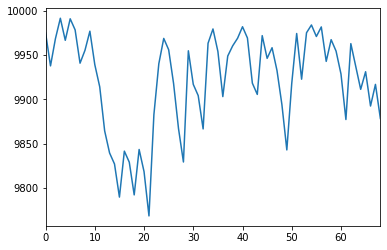

In [9]:
performance.balance.plot()

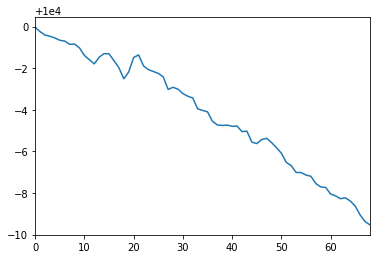

In [10]:
performance.net_worth.plot()

In [11]:
strategy.save_agent(directory='agents')